In [6]:
   !pip install wordcloud

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import SparseCategoricalCrossentropy

In [8]:
df = pd.read_csv("eng-french.csv")
df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [9]:
df.shape

(175621, 2)

In [10]:
# Separating the English and French datasets
eng = df['English words/sentences']
fra = df['French words/sentences']

In [11]:
eng_word_counter = Counter([word for sentence in eng for word in sentence.split()])
print("Total count of English words:",len([word for sentence in eng for word in sentence.split()]))
print("Count of distinct English words:",len(eng_word_counter))
print("10 most common English words:",list(zip(*eng_word_counter.most_common(10)))[0])

Total count of English words: 1082098
Count of distinct English words: 27393
10 most common English words: ('I', 'to', 'you', 'the', 'a', 'is', 'Tom', 'of', 'in', 'have')


In [12]:
fra_word_counter = Counter([word for sentence in fra for word in sentence.split()])
print("Total count of French words:",len([word for sentence in fra for word in sentence.split()]))
print("Count of distinct French words:",len(fra_word_counter))
print("10 most common French words:",list(zip(*fra_word_counter.most_common(10)))[0])

Total count of French words: 1177832
Count of distinct French words: 44918
10 most common French words: ('de', 'Je', '?', 'pas', 'que', 'à', 'ne', 'la', 'le', 'Il')


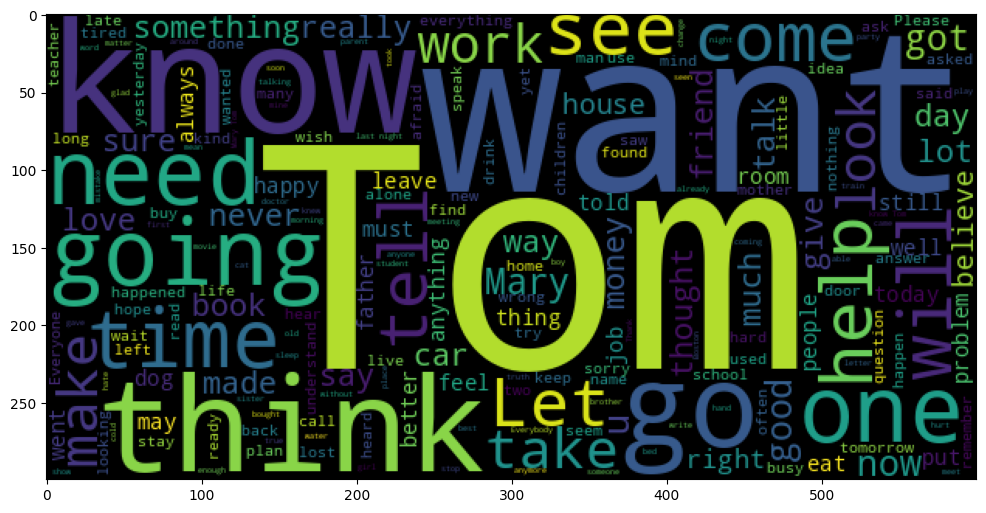

In [13]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(eng))
plt.imshow(wc)
plt.show();

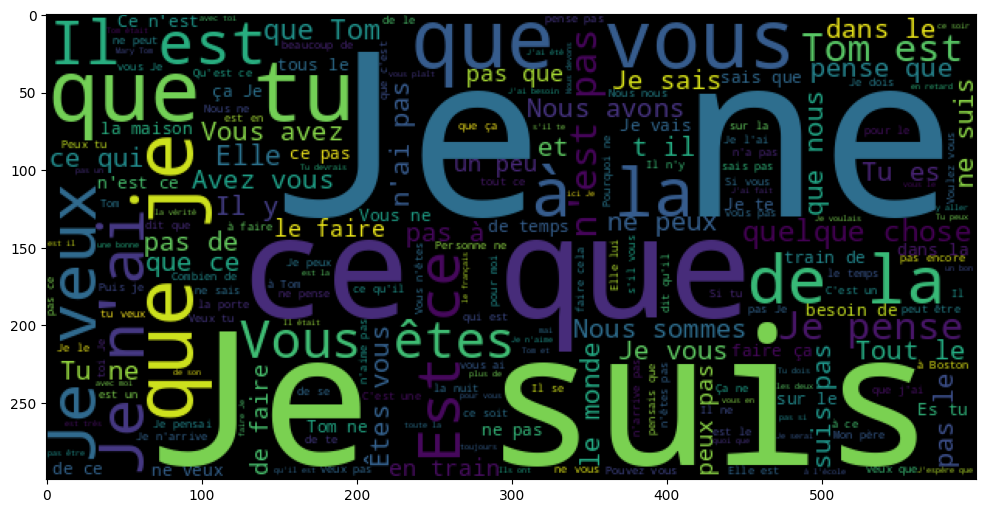

In [14]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(fra))
plt.imshow(wc)
plt.show();

In [15]:
def word_count(line):
  return len(line.split())

In [16]:
df['English_word_count'] = df['English words/sentences'].apply(lambda x: word_count(x))
df['French_word_count'] = df['French words/sentences'].apply(lambda x: word_count(x))

/var/folders/qv/5yjnmpv12fdbfzvx5bhhdxm00000gn/T/ipykernel_25305/1880454391.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['English_word_count'],ax=axes[0])
/var/folders/qv/5yjnmpv12fdbfzvx5bhhdxm00000gn/T/ipykernel_25305/1880454391.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[

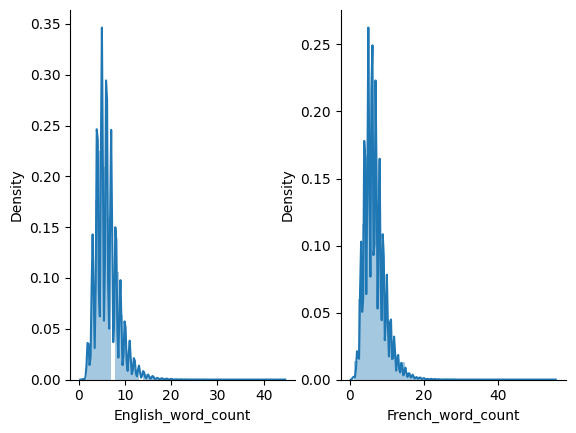

In [17]:
fig, axes = plt.subplots(nrows=1,ncols=2)
sns.distplot(df['English_word_count'],ax=axes[0])
sns.distplot(df['French_word_count'],ax=axes[1])
sns.despine()
plt.show();

In [18]:
def create_tokenizer(sentences):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sentences)
  return tokenizer

In [19]:
def max_sentence_length(lines):
  return max(len(sentence.split()) for sentence in lines)

In [20]:
def encode_sequences(tokenizer,sentences,max_sent_len):
  text_to_seq = tokenizer.texts_to_sequences(sentences) # encode sequences with integers
  text_pad_seq = pad_sequences(text_to_seq,maxlen=max_sent_len,padding='post') # pad sequences with 0
  return text_pad_seq

In [21]:
# Prepare English tokenizer
eng_tokenizer = create_tokenizer(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_eng_sent_len = max_sentence_length(eng)
print("English vocabulary size:", eng_vocab_size)
print("Maximum length of English sentences:", max_eng_sent_len)

English vocabulary size: 14532
Maximum length of English sentences: 44


In [22]:
# Prepare French tokenizer
fra_tokenizer = create_tokenizer(fra)
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_fra_sent_len = max_sentence_length(fra)
print("French vocabulary size:", fra_vocab_size)
print("Maximum length of French sentences:", max_fra_sent_len)

French vocabulary size: 30661
Maximum length of French sentences: 55


In [23]:
max_eng_sent_len = 22
max_fra_sent_len = 22

In [24]:
# Perform encoding of sequences
X = encode_sequences(eng_tokenizer,eng,max_eng_sent_len)
y = encode_sequences(fra_tokenizer,fra,max_fra_sent_len)

In [25]:
df.to_csv('cleaned_eng_french.csv', index=False)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=True,random_state=101)

In [27]:
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, Dot, Softmax, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

max_eng_sentlen = 22
max_fra_sentlen = 22
eng_vocabsize = len(eng_tokenizer.word_index) + 1
fra_vocabsize = len(fra_tokenizer.word_index) + 1

# Encoder
encoder_inputs = Input(shape=(max_eng_sentlen,), name='encoder_inputs')
encoder_embedding = Embedding(eng_vocabsize, 128, mask_zero=True)(encoder_inputs)
encoder_outputs, state_h = GRU(256, return_sequences=True, return_state=True)(encoder_embedding)

# Decoder
decoder_inputs = Input(shape=(max_fra_sentlen,), name='decoder_inputs')
decoder_embedding = Embedding(fra_vocabsize, 128, mask_zero=True)(decoder_inputs)
decoder_outputs, _ = GRU(256, return_sequences=True, return_state=True)(decoder_embedding, initial_state=state_h)

# Manual Attention Mechanism
# Compute attention scores using dot product
attention_scores = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])
attention_weights = Softmax(axis=-1)(attention_scores)

# Apply attention weights to encoder outputs
context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs])

# Concatenate decoder output with context vector
concat_outputs = Concatenate()([decoder_outputs, context_vector])

# Final output layer
output_dense = Dense(fra_vocabsize, activation='softmax')(concat_outputs)

# Create and compile model
attention_model = Model([encoder_inputs, decoder_inputs], output_dense)
attention_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 128)   │  1,860,096 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 22)        │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 22, 128)   │  3,924,608 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ [(None, 22, 256), │    296,448 │ embedding[0][0],  │
│                     │ (None, 256)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 22, 256), │    296,448 │ embedding_1[0][0… │
│                     │ (None, 256)]      │            │ gru[0][1]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 22, 22)    │          0 │ gru_1[0][0],      │
│                     │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 22, 22)    │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 22, 256)   │          0 │ softmax[0][0],    │
│                     │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 22, 512)   │          0 │ gru_1[0][0],      │
│ (Concatenate)       │                   │            │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 22, 30661) │ 15,729,093 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,106,693 (84.33 MB)

 Trainable params: 22,106,693 (84.33 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
import numpy as np
decoder_input_train = np.zeros_like(y_train)
decoder_input_train[:, 1:] = y_train[:, :-1]
decoder_input_train[:, 0] = fra_tokenizer.word_index['<start>'] if '<start>' in fra_tokenizer.word_index else 1

decoder_input_test = np.zeros_like(y_test)
decoder_input_test[:, 1:] = y_test[:, :-1]
decoder_input_test[:, 0] = fra_tokenizer.word_index['<start>'] if '<start>' in fra_tokenizer.word_index else 1


In [ ]:
history = attention_model.fit(
    [X_train, decoder_input_train],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
    validation_data=([X_test, decoder_input_test], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)),
    epochs=6,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=1, restore_best_weights=True, verbose=1),
               ReduceLROnPlateau(monitor='val_accuracy', patience=1, factor=0.5, min_lr=1e-4, verbose=1)],
    verbose=1,
)


Epoch 1/6
   9/1167 ━━━━━━━━━━━━━━━━━━━━ 11:50:27 37s/step - accuracy: 0.4801 - loss: 10.1704

In [ ]:
eval_result = attention_model.evaluate([X_test, decoder_input_test], y_test.reshape(y_test.shape[0], y_test.shape[1], 1))
print(f"Attention Model Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")


824/824 ━━━━━━━━━━━━━━━━━━━━ 86s 104ms/step - accuracy: 0.8863 - loss: 0.6141
Attention Model Test Loss: 0.6161630153656006, Test Accuracy: 0.8862518668174744


In [ ]:
history = attention_model.fit(
    [X_train, decoder_input_train],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
    validation_data=([X_test, decoder_input_test], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)),
    epochs=25,
    batch_size=128,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=1, restore_best_weights=True, verbose=1),
               ReduceLROnPlateau(monitor='val_accuracy', patience=1, factor=0.5, min_lr=1e-4, verbose=1)],
    verbose=1,
)

NameError: name 'attention_model' is not defined

In [ ]:
eval_result = attention_model.evaluate([X_test, decoder_input_test], y_test.reshape(y_test.shape[0], y_test.shape[1], 1))
print(f"Attention Model Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

NameError: name 'attention_model' is not defined

In [ ]:
attention_model.save_weights('best_model.weights.h5')


NameError: name 'attention_model' is not defined

In [ ]:
attention_model.load_weights('best_model.weights.h5')

In [ ]:
# Read the file
with open('extracted_text.txt', 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f if line.strip()]

# Preprocess: tokenize and pad to fit model input
# Use your English tokenizer and max sequence length (adjust variable if needed)
eng_sequences = eng_tokenizer.texts_to_sequences(lines)
eng_sequences = pad_sequences(eng_sequences, maxlen=max_eng_sentlen, padding='post')


In [ ]:
import numpy as np
# Create the initial decoder input: <start> token followed by zeros
start_token = fra_tokenizer.word_index.get('<start>', 1)
batch_size = eng_sequences.shape[0]
decoder_input = np.zeros((batch_size, max_fra_sentlen), dtype=int)
decoder_input[:, 0] = start_token


In [ ]:
# Run inference (greedy approach)
preds = attention_model.predict([eng_sequences, decoder_input])
pred_ids = preds.argmax(axis=-1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [ ]:
import numpy as np

# Reverse French tokenizer index for decoding
reverse_fra_word_index = {idx: word for word, idx in fra_tokenizer.word_index.items()}

def decode_sequence(input_seq, max_len=max_fra_sentlen):
    # input_seq is already tokenized and padded numpy array shape (1, max_eng_sentlen)
    
    start_token = fra_tokenizer.word_index.get('<start>', 1)
    end_token = fra_tokenizer.word_index.get('<end>', 2)
    
    # Initialize decoder input with <start> token
    decoded_seq = [start_token]
    
    for i in range(max_len - 1):
        # Prepare decoder input array with current decoded sequence
        decoder_input = np.zeros((1, max_len))
        decoder_input[0, :len(decoded_seq)] = decoded_seq
        
        # Predict next token probabilities for current decoder input
        preds = attention_model.predict([input_seq, decoder_input])
        
        # Greedy sampling: pick token with highest prob at current step (length of decoded_seq - 1)
        next_token = np.argmax(preds[0, len(decoded_seq) - 1, :])
        decoded_seq.append(next_token)
        
        # Stop if <end> token is predicted
        if next_token == end_token:
            break
    
    # Convert tokens to words, skipping special tokens
    words = []
    for token in decoded_seq:
        if token in [start_token, end_token, 0]:
            continue
        word = reverse_fra_word_index.get(token, '')
        if word:
            words.append(word)
    
    return ' '.join(words)


# Read your new file and preprocess
with open('extracted_text.txt', 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f if line.strip()]

# Tokenize and pad input lines
seqs = eng_tokenizer.texts_to_sequences(lines)
seqs_padded = pad_sequences(seqs, maxlen=max_eng_sentlen, padding='post')

# Generate translations using stepwise decoding
translations = []
for seq in seqs_padded:
    input_seq = np.expand_dims(seq, axis=0)  # shape (1, max_eng_sentlen)
    translation = decode_sequence(input_seq)
    translations.append(translation)

# Display translations
for inp, trans in zip(lines, translations):
    print(f"EN: {inp}\nFR: [translate:{trans}]\n")


NameError: name 'fra_tokenizer' is not defined

In [ ]:
def beam_search_decode(input_seq, beam_width=3, max_len=max_fra_sentlen):
    start_token = fra_tokenizer.word_index.get('<start>', 1)
    end_token = fra_tokenizer.word_index.get('<end>', 2)

    sequences = [[list([start_token]), 0.0]]
    
    for _ in range(max_len):
        all_candidates = []
        for seq, score in sequences:
            decoder_input = np.zeros((1, max_len))
            decoder_input[0, :len(seq)] = seq
            preds = attention_model.predict([input_seq, decoder_input])
            log_probs = np.log(preds[0, len(seq)-1, :] + 1e-10)

            # Select top beam_width tokens
            top_tokens = np.argsort(log_probs)[-beam_width:]
            for token in top_tokens:
                candidate = [seq + [token], score - log_probs[token]]
                all_candidates.append(candidate)

        # Order all candidates by score and select best beam_width
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        sequences = ordered[:beam_width]

        # Check if any sequence ended with end_token
        best_seq, best_score = sequences[0]
        if best_seq[-1] == end_token:
            break

    # Decode token to words
    reverse_index = {v:k for k,v in fra_tokenizer.word_index.items()}
    words = [reverse_index.get(i, '') for i in best_seq if i not in [start_token, end_token, 0]]
    return ' '.join(words)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Beam search decoding function
def beam_search_decode(input_seq, beam_width=3, max_len=max_fra_sentlen):
    start_token = fra_tokenizer.word_index.get('<start>', 1)
    end_token = fra_tokenizer.word_index.get('<end>', 2)

    sequences = [[list([start_token]), 0.0]]  # (sequence, score)

    for _ in range(max_len):
        all_candidates = []
        for seq, score in sequences:
            decoder_input = np.zeros((1, max_len))
            decoder_input[0, :len(seq)] = seq

            preds = attention_model.predict([input_seq, decoder_input])
            log_probs = np.log(preds[0, len(seq) - 1, :] + 1e-10)  # Add epsilon to avoid log(0)

            top_tokens = np.argsort(log_probs)[-beam_width:]
            for token in top_tokens:
                candidate = [seq + [token], score - log_probs[token]]
                all_candidates.append(candidate)

        sequences = sorted(all_candidates, key=lambda tup: tup[1])[:beam_width]

        best_seq, best_score = sequences[0]
        if best_seq[-1] == end_token:
            break

    reverse_fra_word_index = {idx: word for word, idx in fra_tokenizer.word_index.items()}
    words = [reverse_fra_word_index.get(i, '') for i in best_seq if i not in [start_token, end_token, 0]]
    return ' '.join(words)


# Read and preprocess new sentences from file
with open('extracted_text.txt', 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f if line.strip()]

seqs = eng_tokenizer.texts_to_sequences(lines)
seqs_padded = pad_sequences(seqs, maxlen=max_eng_sentlen, padding='post')

# Generate translations using beam search decoding
translations = []
for seq in seqs_padded:
    input_seq = np.expand_dims(seq, axis=0)
    translation = beam_search_decode(input_seq, beam_width=5)
    translations.append(translation)

# Print results, surrounding translations with [translate:...] tags
for inp, trans in zip(lines, translations):
    print(f"EN: {inp}\nFR: [translate:{trans}]\n")


NameError: name 'max_fra_sentlen' is not defined